# 1. Lectura del dataset con pandas

In [1]:
import pandas as pd
import os
import numpy as np # version 1.26.4 (pip install numpy==1.26.4)
from sklearn.impute import KNNImputer
from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings

In [2]:
carpeta = 'dataset_historico_id_3195'
lista_data = os.listdir(carpeta)

fichero = max(list(filter(lambda x: x.endswith('.jsonl'), lista_data)))

ruta = os.path.join(carpeta, fichero)
df = pd.read_json(ruta, lines = True)
df

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,...,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,sol
0,2024-11-07,3195,"MADRID, RETIRO",MADRID,667,"15,0","0,0","11,2",06:30,"18,9",...,"946,4",09,"943,3",Varias,78.0,93.0,Varias,62.0,15:30,NaN
1,2024-11-08,3195,"MADRID, RETIRO",MADRID,667,"13,4","0,0","11,1",23:59,"15,7",...,"945,7",Varias,"943,0",Varias,90.0,99.0,23:00,78.0,14:20,NaN
2,2024-11-09,3195,"MADRID, RETIRO",MADRID,667,"13,1","0,0","9,6",05:30,"16,6",...,"948,3",22,"945,2",04,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-11-10,3195,"MADRID, RETIRO",MADRID,667,"12,6","0,0","8,8",03:40,"16,3",...,"948,7",10,"946,1",Varias,79.0,94.0,Varias,67.0,11:40,NaN
4,2024-11-11,3195,"MADRID, RETIRO",MADRID,667,"13,3","0,0","9,6",05:00,"17,0",...,"948,1",10,"945,7",15,65.0,97.0,05:00,44.0,15:20,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38439,1920-04-11,3195,"MADRID, RETIRO",MADRID,667,"11,6","1,6","7,0",06:00,"16,1",...,"939,3",11,"935,7",24,75.0,NaN,NaN,NaN,NaN,"5,3"
38440,1920-04-12,3195,"MADRID, RETIRO",MADRID,667,"11,2","1,3","9,0",23:59,"13,3",...,"935,7",00,"927,0",15,NaN,NaN,NaN,NaN,NaN,"1,7"
38441,1920-04-13,3195,"MADRID, RETIRO",MADRID,667,"10,4","0,9","5,8",00:00,"15,1",...,"938,5",21,"930,2",00,NaN,NaN,NaN,NaN,NaN,"2,8"
38442,1920-04-14,3195,"MADRID, RETIRO",MADRID,667,"13,0","0,0","8,8",00:00,"17,1",...,"939,4",21,"937,1",02,NaN,NaN,NaN,NaN,NaN,"3,9"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38444 entries, 0 to 38443
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fecha        38444 non-null  object 
 1   indicativo   38444 non-null  int64  
 2   nombre       38444 non-null  object 
 3   provincia    38444 non-null  object 
 4   altitud      38444 non-null  int64  
 5   tmed         38308 non-null  object 
 6   prec         37479 non-null  object 
 7   tmin         38308 non-null  object 
 8   horatmin     37424 non-null  object 
 9   tmax         38310 non-null  object 
 10  horatmax     37458 non-null  object 
 11  dir          29946 non-null  float64
 12  velmedia     33016 non-null  object 
 13  racha        30037 non-null  object 
 14  horaracha    29664 non-null  object 
 15  presMax      36981 non-null  object 
 16  horaPresMax  36981 non-null  object 
 17  presMin      36981 non-null  object 
 18  horaPresMin  36979 non-null  object 
 19  hrMe

# 2. Pre-procesamiento

Los campos indicativo, nombre, provincia y altitud son los mismos para todos los registros, por lo que no es necesario incluirlos en el dataframe.m

In [4]:
df = df[df.columns[5:].insert(0, 'fecha')] # Se filtra el dataframe para que contenga solo las columnas de interés

Se pone en formato fecha la columna de fechas, que va a ser el campo índice

In [5]:
df["fecha"] = pd.to_datetime(df["fecha"])
df.set_index("fecha", inplace=True)
df.sort_index(inplace=True, ascending=False)

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\2099670388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fecha"] = pd.to_datetime(df["fecha"])
C:\Users\felix\AppData\Local\Temp\ipykernel_14300\2099670388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_index(inplace=True, ascending=False)


Hay campos numericos que pandas lee como texto debido a que el decimal es una coma y no un punto. Por lo tanto, se sustituye las comas por puntos. Además, interesa poner el formato hora en formato numérico

In [6]:
df.replace(',','.', regex=True, inplace=True)
df.replace(':','.', regex = True, inplace = True) 
# Se reemplazan las comas por puntos y los dos puntos por puntos para poder convertir a float
columnas_numericas = ['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'racha', 'presMax', 'presMin', 'sol']
for col in columnas_numericas:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.info()

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\3586366732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(',','.', regex=True, inplace=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38444 entries, 2025-05-06 to 1920-01-01
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tmed         38308 non-null  float64
 1   prec         36071 non-null  float64
 2   tmin         38308 non-null  float64
 3   horatmin     37424 non-null  object 
 4   tmax         38310 non-null  float64
 5   horatmax     37458 non-null  object 
 6   dir          29946 non-null  float64
 7   velmedia     33016 non-null  float64
 8   racha        30037 non-null  float64
 9   horaracha    29664 non-null  object 
 10  presMax      36981 non-null  float64
 11  horaPresMax  36981 non-null  object 
 12  presMin      36981 non-null  float64
 13  horaPresMin  36979 non-null  object 
 14  hrMedia      37071 non-null  float64
 15  hrMax        5982 non-null   float64
 16  horaHrMax    5982 non-null   object 
 17  hrMin        5981 non-null   float64
 18  horaHrMin    5980 non-null   

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\3586366732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(':','.', regex = True, inplace = True)
C:\Users\felix\AppData\Local\Temp\ipykernel_14300\3586366732.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


Hay campos cuyo valor es igual a "varias". Se reemplaza el valor 'Varias' por NaN para poder convertir a float los campos de horas y porque se decide que no es suficientemente informativo

In [7]:
df[df["horatmin"] == "Varias"]

,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,sol
fecha,,,,,,,,,,,,,,,,,,,,
2025-04-20,11.2,0.0,6.2,Varias,16.2,14.20,5.0,2.2,10.0,00.10,937.1,24,929.2,04,63.0,96.0,Varias,39.0,14.30,NaN
2025-04-17,12.8,0.0,6.2,Varias,19.3,15.30,14.0,3.1,9.7,07.50,939.2,23,936.7,02,53.0,99.0,00.00,34.0,12.40,NaN
2025-04-15,8.8,0.0,6.2,Varias,11.5,11.40,21.0,1.7,11.4,19.10,932.6,24,926.2,03,71.0,98.0,04.00,51.0,18.10,NaN
2025-04-07,15.8,0.0,8.8,Varias,22.8,14.20,27.0,1.1,5.3,14.00,941.9,24,938.2,01,56.0,94.0,03.30,30.0,14.50,NaN
2025-03-29,12.8,0.0,6.2,Varias,19.3,14.30,2.0,1.7,10.8,16.30,943.2,10,940.4,17,51.0,86.0,06.50,23.0,14.30,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921-07-26,26.0,0.0,17.8,Varias,34.3,15.30,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN
1921-06-25,22.5,0.0,15.6,Varias,29.4,14.50,20.0,0.6,3.1,16.30,942.6,Varias,941.3,18,53.0,NaN,NaN,NaN,NaN,12.5
1921-02-27,7.2,8.9,5.6,Varias,8.8,15.00,NaN,2.5,NaN,NaN,954.5,24,948.6,00,91.0,NaN,NaN,NaN,NaN,0.0


Se sustituye los valores de "Varias" por valores nulos

In [8]:
df.replace('Varias', np.nan, inplace=True)
lista_campos_horas = ['horatmin', 'horatmax', 'horaracha', 'horaHrMax', 'horaHrMin', 'horaPresMax', 'horaPresMin']
df[lista_campos_horas] = df[lista_campos_horas].astype(float) # Se convierten los campos de horas a float

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\1204205693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('Varias', np.nan, inplace=True)
C:\Users\felix\AppData\Local\Temp\ipykernel_14300\1204205693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lista_campos_horas] = df[lista_campos_horas].astype(float) # Se convierten los campos de horas a float


El campo "dir" que indica la dirección de la racha máxima, de acuerdo con los metadatos si toma los siguientes valores ocurre lo siguiente:

- Si es = 99, entonces la direccion del viento es variable.
- Si es = 88, entonces no hay dato.

Por lo tanto, se decide sustituir los valores 99 y 88 por valores nulos

In [9]:
df["dir"].replace(99, np.nan, inplace=True)
df["dir"].replace(99, np.nan, inplace=True)

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\3123448252.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dir"].replace(99, np.nan, inplace=True)
C:\Users\felix\AppData\Local\Temp\ipykernel_14300\3123448252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dir"].replace(99, np.nan, inplace=True)
C:\Users\felix\AppData\Local\Te

Se comprueba que todos los campos son numéricos

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38444 entries, 2025-05-06 to 1920-01-01
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tmed         38308 non-null  float64
 1   prec         36071 non-null  float64
 2   tmin         38308 non-null  float64
 3   horatmin     35789 non-null  float64
 4   tmax         38310 non-null  float64
 5   horatmax     36139 non-null  float64
 6   dir          29459 non-null  float64
 7   velmedia     33016 non-null  float64
 8   racha        30037 non-null  float64
 9   horaracha    28860 non-null  float64
 10  presMax      36981 non-null  float64
 11  horaPresMax  35521 non-null  float64
 12  presMin      36981 non-null  float64
 13  horaPresMin  35344 non-null  float64
 14  hrMedia      37071 non-null  float64
 15  hrMax        5982 non-null   float64
 16  horaHrMax    4321 non-null   float64
 17  hrMin        5981 non-null   float64
 18  horaHrMin    4545 non-null   

## 2.1 Tratamiento de outliers

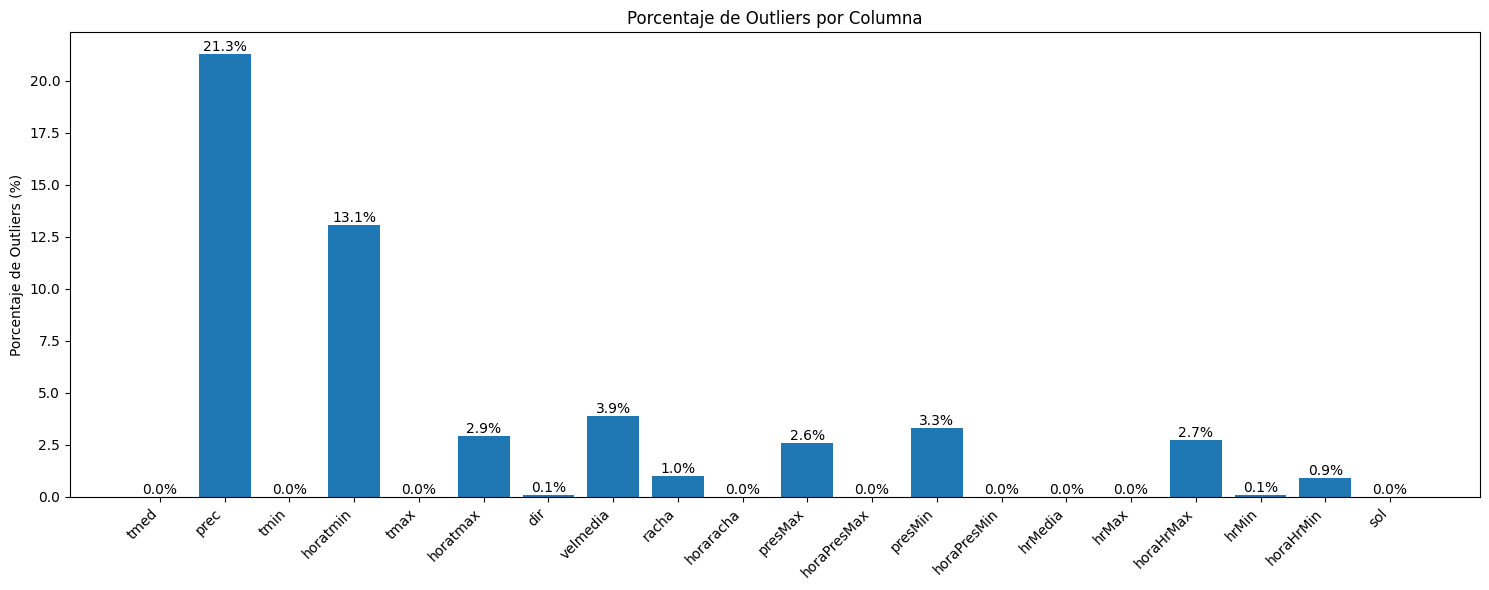

Columna tmed:
- Outliers eliminados: 136. Es decir, un 0.35% de los datos.
- Límite inferior: -10.20
- Límite superior: 39.40

Columna prec:
- Outliers eliminados: 10645. Es decir, un 27.69% de los datos.
- Límite inferior: -0.15
- Límite superior: 0.25

Columna tmin:
- Outliers eliminados: 10645. Es decir, un 27.69% de los datos.
- Límite inferior: -11.10
- Límite superior: 30.50

Columna horatmin:
- Outliers eliminados: 14188. Es decir, un 36.91% de los datos.
- Límite inferior: 2.75
- Límite superior: 9.55

Columna tmax:
- Outliers eliminados: 14188. Es decir, un 36.91% de los datos.
- Límite inferior: -9.70
- Límite superior: 48.70

Columna horatmax:
- Outliers eliminados: 15088. Es decir, un 39.25% de los datos.
- Límite inferior: 10.75
- Límite superior: 17.55

Columna dir:
- Outliers eliminados: 19980. Es decir, un 51.97% de los datos.
- Límite inferior: -26.50
- Límite superior: 57.50

Columna velmedia:
- Outliers eliminados: 20546. Es decir, un 53.44% de los datos.
- Límite in

In [11]:
# Función para detectar y eliminar outliers usando el método IQR
def eliminar_outliers(df, columnas):
    df_limpio = df.copy()
    
    for columna in columnas:
        # Calcular Q1, Q3 y IQR
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        
        # Definir límites
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Filtrar outliers
        df_limpio = df_limpio[
            (df_limpio[columna] >= limite_inferior) & 
            (df_limpio[columna] <= limite_superior)
        ]
        
        print(f"Columna {columna}:")
        print(f"- Outliers eliminados: {len(df) - len(df_limpio)}. Es decir, un {((len(df) - len(df_limpio)) / len(df)) * 100:.2f}% de los datos.")
        print(f"- Límite inferior: {limite_inferior:.2f}")
        print(f"- Límite superior: {limite_superior:.2f}\n")
    
    return df_limpio

# Aplicar a columnas numéricas excluyendo fechas y horas
columnas_a_revisar = df.columns

# Calcular y visualizar los outliers por columna
outliers_por_columna = {}
for columna in columnas_a_revisar:
    # Calcular Q1, Q3 y IQR
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir límites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Identificar outliers
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    porcentaje_outliers = (len(outliers) / len(df)) * 100
    outliers_por_columna[columna] = porcentaje_outliers

# Visualizar los outliers por columna
plt.figure(figsize=(15, 6))
plt.bar(outliers_por_columna.keys(), outliers_por_columna.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel('Porcentaje de Outliers (%)')
plt.title('Porcentaje de Outliers por Columna')
for i, v in enumerate(outliers_por_columna.values()):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Eliminar outliers
df_limpio = eliminar_outliers(df, columnas_a_revisar)

# Mostrar dimensiones antes y después
print(f"Dimensiones originales: {df.shape}")
print(f"Dimensiones después de eliminar outliers: {df_limpio.shape}")

No se eliminan los outliers porque se pasaría a tener muy pocos datos

# 3. Visualizaciones de los datos

## 3.1 Precipitación

<Axes: xlabel='fecha'>

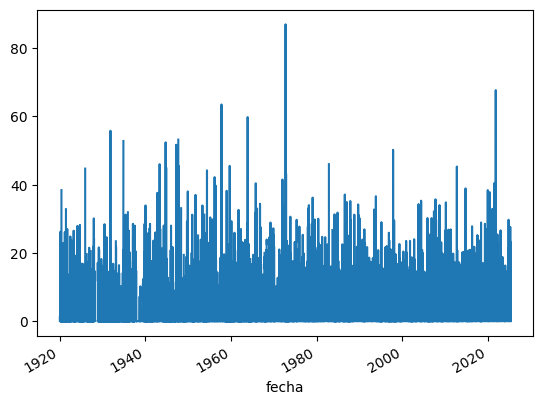

In [12]:
df["prec"].plot() # Gráfico de la precipitación con una frecuencia diaria

## Los datos son diarios, pero si se agrupan por años, es más visual

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\2142240133.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  precipitacion_anual = df['prec'].resample('Y').sum()


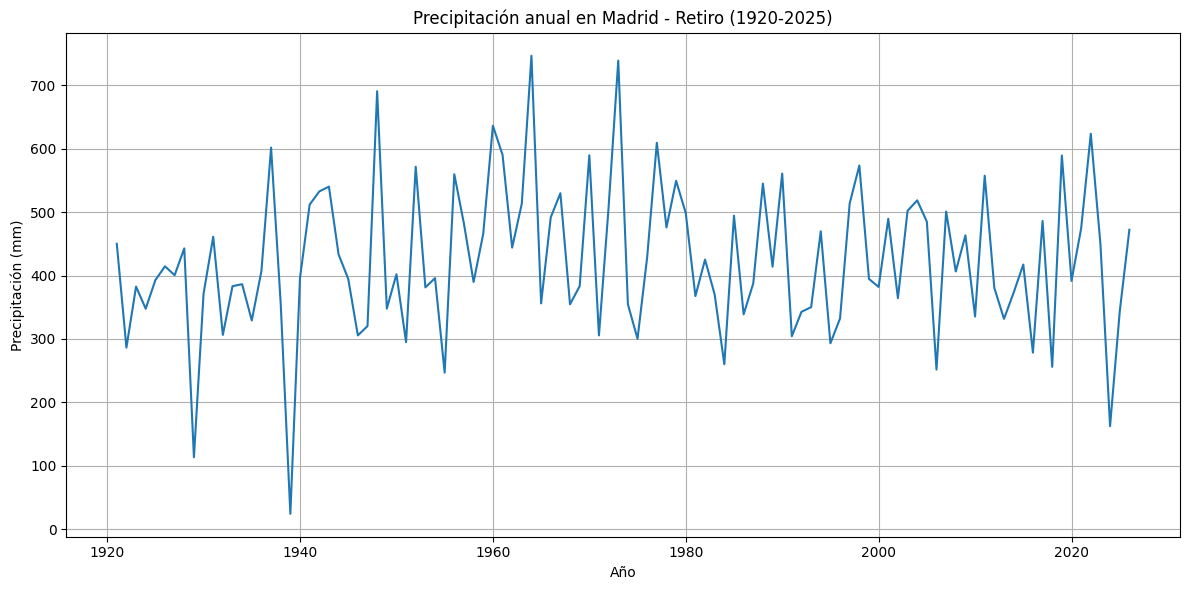

In [13]:
precipitacion_anual = df['prec'].resample('Y').sum()

plt.figure(figsize=(12, 6))
plt.plot(precipitacion_anual.index, precipitacion_anual.values)
plt.title('Precipitación anual en Madrid - Retiro (1920-2025)')
plt.xlabel('Año')
plt.ylabel('Precipitación (mm)')
plt.grid(True)
plt.tight_layout()

## 3.2 Temperatura

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\4294586574.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  temperaturas = df[['tmin','tmed','tmax']].resample('Y').mean().iloc[:-1]


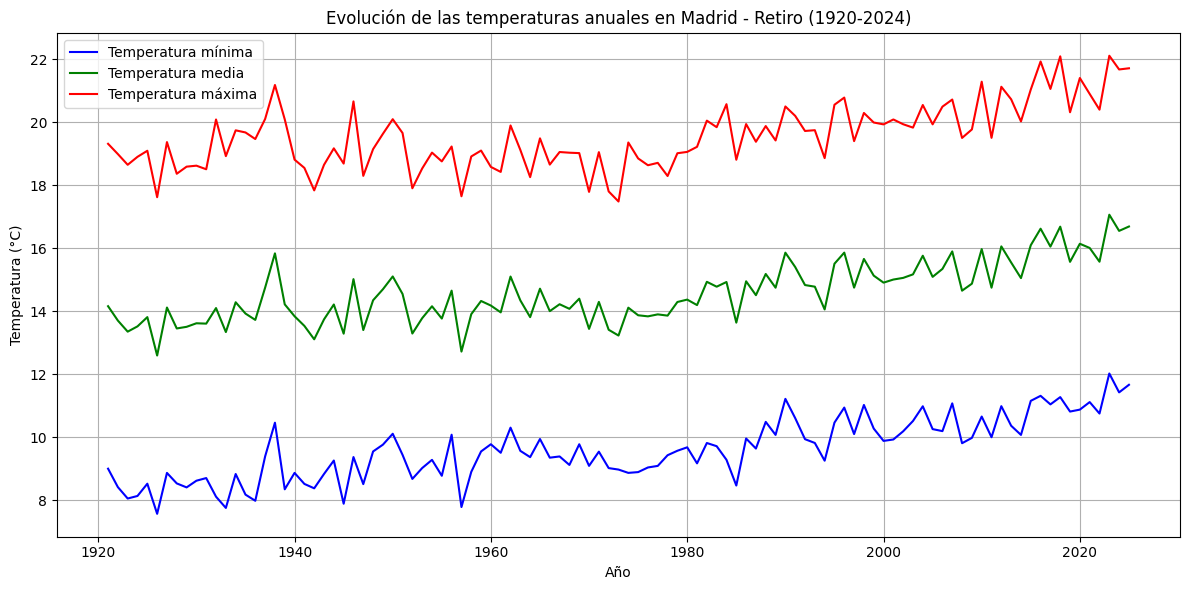

In [14]:
temperaturas = df[['tmin','tmed','tmax']].resample('Y').mean().iloc[:-1]

plt.figure(figsize=(12, 6))
plt.plot(temperaturas.index, temperaturas['tmin'], label='Temperatura mínima', color='blue')
plt.plot(temperaturas.index, temperaturas['tmed'], label='Temperatura media', color='green')
plt.plot(temperaturas.index, temperaturas['tmax'], label='Temperatura máxima', color='red')
plt.title('Evolución de las temperaturas anuales en Madrid - Retiro (1920-2024)')
plt.xlabel('Año')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\2497395775.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  hora_temperaturas = df[['horatmin','horatmax']].resample('Y').mean()


<Axes: xlabel='fecha'>

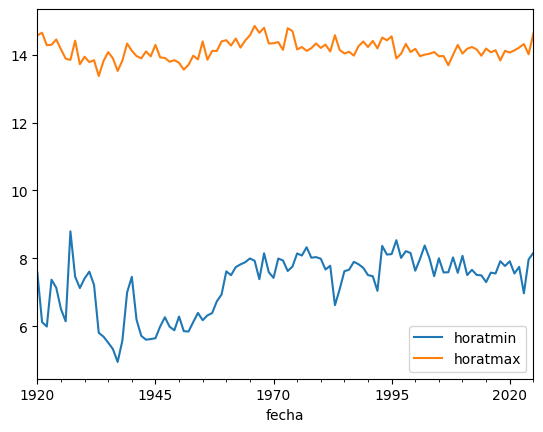

In [15]:
hora_temperaturas = df[['horatmin','horatmax']].resample('Y').mean()
hora_temperaturas.plot()

## 3.3 Insolación

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\3207120584.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  insolacion = df[['sol']].resample('Y').mean()


<Axes: xlabel='fecha'>

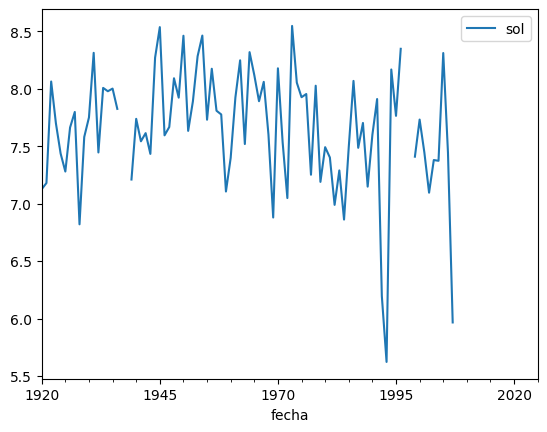

In [16]:
insolacion = df[['sol']].resample('Y').mean()
insolacion.plot()

## 3.4 Presión

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\2171022622.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  presiones = df[['presMin', 'presMax']].resample('Y').mean()


<Axes: xlabel='fecha'>

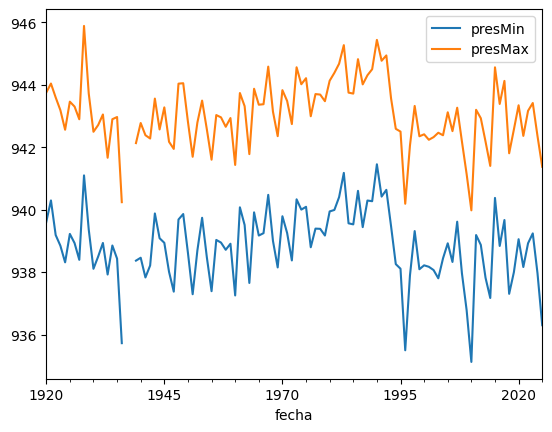

In [17]:
presiones = df[['presMin', 'presMax']].resample('Y').mean()
presiones.plot()

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\2036376267.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  hora_presiones = df[['horaPresMin', 'horaPresMax']].resample('Y').mean()


<Axes: xlabel='fecha'>

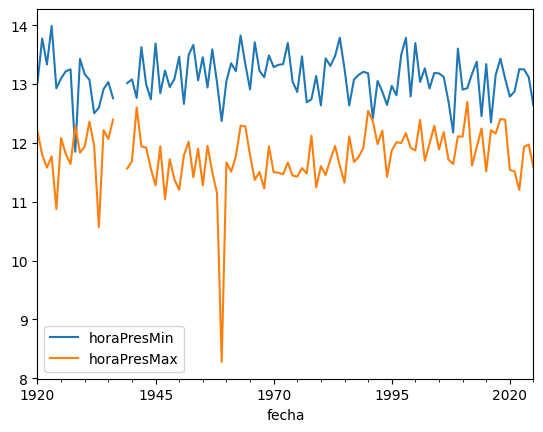

In [18]:
hora_presiones = df[['horaPresMin', 'horaPresMax']].resample('Y').mean()
hora_presiones.plot()

## 3.5 Humedad

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\2141779905.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  humedad = df[['hrMin', 'hrMedia', 'hrMax']].resample('Y').mean()


<Axes: xlabel='fecha'>

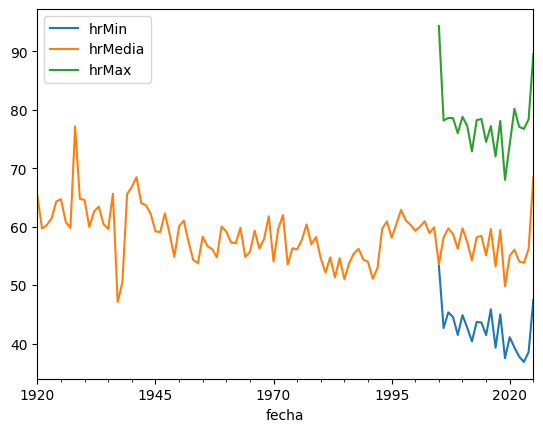

In [19]:
humedad = df[['hrMin', 'hrMedia', 'hrMax']].resample('Y').mean()
humedad.plot()

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\199392318.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  hora_humedades = df[['horaHrMin', 'horaHrMax']].resample('Y').mean()


<Axes: xlabel='fecha'>

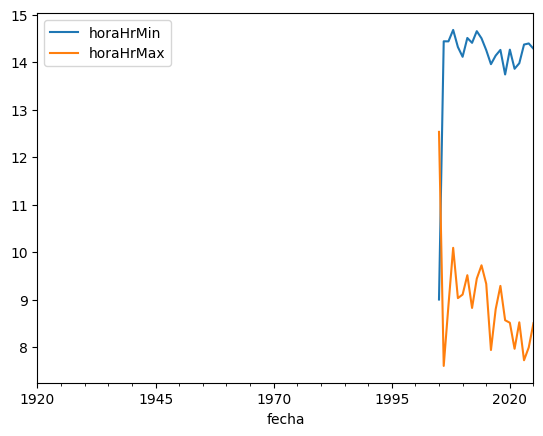

In [20]:
hora_humedades = df[['horaHrMin', 'horaHrMax']].resample('Y').mean()
hora_humedades.plot()

## 3.6 Viento

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\40040869.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  viento = df[['velmedia', 'racha']].resample('Y').mean()


<Axes: xlabel='fecha'>

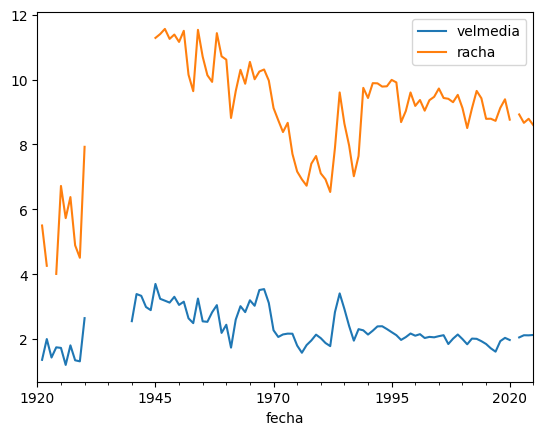

In [21]:
viento = df[['velmedia', 'racha']].resample('Y').mean()
viento.plot()

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\481535316.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  hora_viento = df[['horaracha']].resample('Y').mean()


<Axes: xlabel='fecha'>

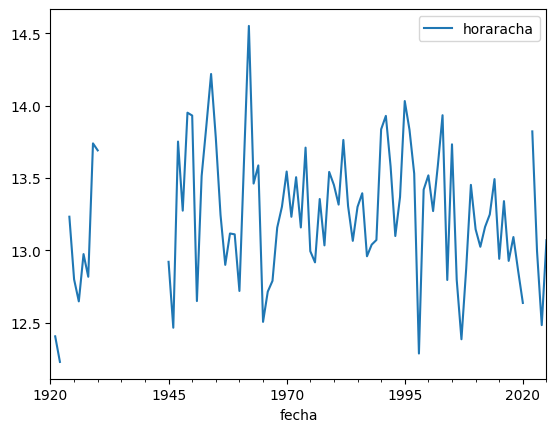

In [22]:
hora_viento = df[['horaracha']].resample('Y').mean()
hora_viento.plot()

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\2283382415.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  direccion_viento = df[['dir']].resample('Y').mean()


<Axes: xlabel='fecha'>

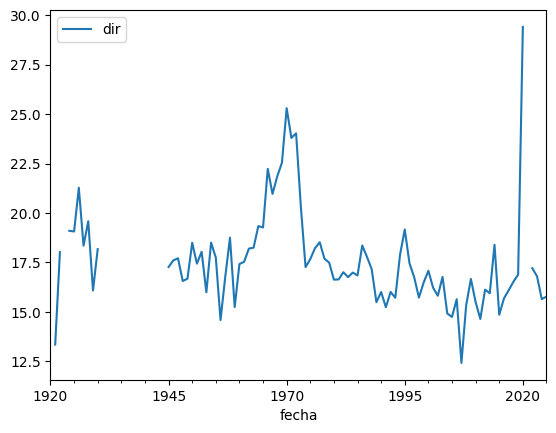

In [23]:
direccion_viento = df[['dir']].resample('Y').mean()
direccion_viento.plot()

## 3.7 Resumen estadístico del DataFrame

In [24]:
df.describe()

,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,sol
count,38308.000000,36071.000000,38308.000000,35789.000000,38310.000000,36139.000000,29459.000000,33016.000000,30037.000000,28860.000000,36981.000000,35521.000000,36981.000000,35344.000000,37071.000000,5982.000000,4321.000000,5981.000000,4545.000000,28654.000000
mean,14.558899,1.245970,9.587350,7.256538,19.530399,14.142863,17.580841,2.353959,8.967836,13.246799,943.074652,11.756961,938.869127,13.122906,58.230450,76.499331,8.745825,41.537034,14.239897,7.687189
std,7.398959,3.884579,6.459933,5.142408,8.590429,2.048823,11.130477,1.841794,4.051662,6.745138,5.656910,8.858206,6.397058,7.962550,18.252125,16.458870,7.062064,17.309629,3.725272,4.158511
min,-6.600000,0.000000,-10.100000,0.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,912.200000,0.000000,902.900000,0.000000,13.000000,30.000000,0.000000,5.000000,0.000000,0.000000
25%,8.400000,0.000000,4.500000,5.300000,12.200000,13.300000,5.000000,1.100000,6.100000,9.100000,939.800000,7.000000,935.500000,4.000000,43.000000,63.000000,5.000000,28.000000,13.400000,4.600000
50%,13.700000,0.000000,9.000000,6.000000,18.600000,14.100000,20.000000,1.900000,8.600000,14.300000,943.100000,10.000000,939.200000,17.000000,56.000000,78.000000,6.300000,38.000000,15.000000,8.500000
75%,20.800000,0.100000,14.900000,7.000000,26.800000,15.000000,26.000000,3.100000,11.400000,18.000000,946.500000,23.000000,942.800000,18.000000,72.000000,92.000000,8.100000,53.000000,16.000000,11.000000
max,33.400000,87.000000,26.200000,23.590000,40.700000,23.590000,88.000000,16.900000,32.200000,23.590000,967.300000,24.000000,962.300000,24.000000,100.000000,100.000000,23.590000,98.000000,23.590000,14.900000


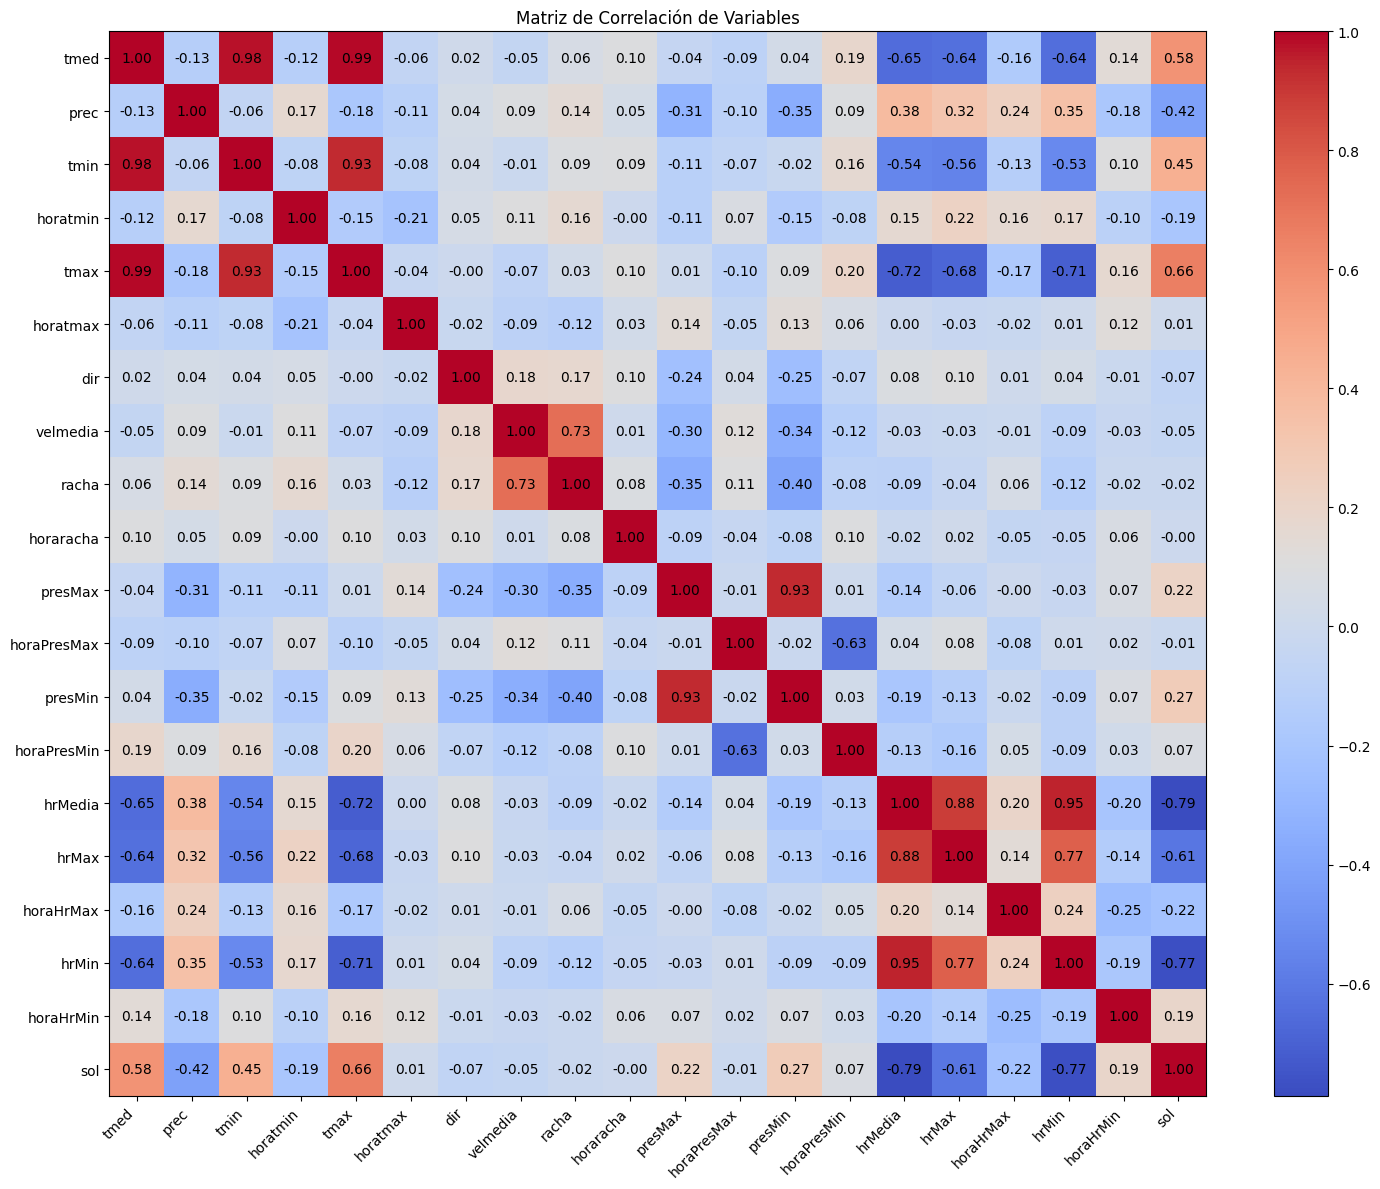

In [25]:
# Create correlation matrix
correlation_matrix = df.corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(15, 12))
im = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')

# Add colorbar
plt.colorbar(im)

# Add labels
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(correlation_matrix.columns)

# Add correlation values
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha='center', va='center')

plt.title('Matriz de Correlación de Variables')
plt.tight_layout()
plt.show()

# 4. Se prepara el DataFrame para un análisis de series temporales

## 4.1 Se define el período de tiempo que se analiza y se eliminan aquellos campos que tienen muchos valores nulos

Se obtiene la fecha mínima de la columna hrMin (la ultima fila con datos, ya que el dataframe está ordenado de forma descendente)

In [26]:
fecha_min_hrMin = df[df["hrMin"].notnull()].iloc[[-1]].index[0] 
fecha_min_hrMax = df[df["hrMax"].notnull()].iloc[[-1]].index[0]

print(f"Fecha mínima de hrMin: {fecha_min_hrMin}")
print(f"Fecha máxima de hrMin: {fecha_min_hrMax}")

Fecha mínima de hrMin: 2005-12-05 00:00:00
Fecha máxima de hrMin: 2005-12-05 00:00:00


La fecha mínima de la humedad máxima y mínima (que es la misma) sin valores nulos es el comienzo de las series temporales a analizar. 

In [27]:
filtro_st = df.index >= fecha_min_hrMin

In [28]:
df_st = df[filtro_st]
df_st

,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin,sol
fecha,,,,,,,,,,,,,,,,,,,,
2025-05-06,12.8,0.0,8.3,5.40,17.3,15.20,33.0,1.9,8.9,23.0,937.2,9.0,934.7,16.0,52.0,80.0,0.0,38.0,16.3,NaN
2025-05-05,13.8,19.4,10.3,3.50,17.2,10.10,22.0,1.4,7.8,22.0,936.1,24.0,932.5,15.0,89.0,99.0,4.4,65.0,10.1,NaN
2025-05-04,14.0,2.8,11.5,8.30,16.6,12.30,7.0,2.8,10.8,15.4,936.7,0.0,933.3,18.0,82.0,98.0,8.2,59.0,15.4,NaN
2025-05-03,15.8,0.9,11.2,3.20,20.4,14.40,4.0,1.7,12.2,19.4,938.2,NaN,935.4,17.0,65.0,97.0,3.3,41.0,16.1,NaN
2025-05-02,15.0,13.6,10.5,7.10,19.5,14.20,9.0,2.8,11.9,6.2,937.5,9.0,932.7,5.0,80.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-09,9.1,0.0,4.6,6.55,13.6,13.00,20.0,2.5,11.1,13.1,951.9,23.0,947.9,16.0,65.0,NaN,NaN,NaN,NaN,7.9
2005-12-08,7.8,0.0,4.0,NaN,11.7,14.15,35.0,1.4,4.7,22.0,949.0,24.0,945.9,NaN,74.0,NaN,NaN,NaN,NaN,6.5
2005-12-07,7.6,0.0,4.3,NaN,10.8,14.00,25.0,1.1,16.1,14.3,946.9,24.0,941.5,0.0,69.0,NaN,NaN,NaN,NaN,8.0


In [29]:
df_st.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7092 entries, 2025-05-06 to 2005-12-05
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tmed         7070 non-null   float64
 1   prec         6932 non-null   float64
 2   tmin         7070 non-null   float64
 3   horatmin     6466 non-null   float64
 4   tmax         7070 non-null   float64
 5   horatmax     6703 non-null   float64
 6   dir          6121 non-null   float64
 7   velmedia     6378 non-null   float64
 8   racha        6306 non-null   float64
 9   horaracha    6103 non-null   float64
 10  presMax      7028 non-null   float64
 11  horaPresMax  6357 non-null   float64
 12  presMin      7028 non-null   float64
 13  horaPresMin  6305 non-null   float64
 14  hrMedia      7030 non-null   float64
 15  hrMax        5982 non-null   float64
 16  horaHrMax    4321 non-null   float64
 17  hrMin        5981 non-null   float64
 18  horaHrMin    4545 non-null   f

El campo "sol" tiene un 92,4 % de datos nulos. El resto de campos no supera el 50 % de valores nulos

In [30]:
(df_st.isna().sum() / len(df_st) * 100).round(1).sort_values(ascending = False)

sol            92.4
horaHrMax      39.1
horaHrMin      35.9
hrMax          15.7
hrMin          15.7
horaracha      13.9
dir            13.7
racha          11.1
horaPresMin    11.1
horaPresMax    10.4
velmedia       10.1
horatmin        8.8
horatmax        5.5
prec            2.3
presMax         0.9
hrMedia         0.9
presMin         0.9
tmax            0.3
tmin            0.3
tmed            0.3
dtype: float64

Se elimina el campo "sol"

In [31]:
df_st.drop("sol", axis = 1, inplace = True)

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\3900998306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_st.drop("sol", axis = 1, inplace = True)


## 4.2 Sustitución de los valores nulos

Los valores nulos son sustituidos por la media entre los 15 valores más cercanos

In [32]:
imputer = KNNImputer(n_neighbors = 1)
df_st_imputed = imputer.fit_transform(df_st)
df_st = pd.DataFrame(df_st_imputed, columns = df_st.columns, index = df_st.index)
df_st.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7092 entries, 2025-05-06 to 2005-12-05
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tmed         7092 non-null   float64
 1   prec         7092 non-null   float64
 2   tmin         7092 non-null   float64
 3   horatmin     7092 non-null   float64
 4   tmax         7092 non-null   float64
 5   horatmax     7092 non-null   float64
 6   dir          7092 non-null   float64
 7   velmedia     7092 non-null   float64
 8   racha        7092 non-null   float64
 9   horaracha    7092 non-null   float64
 10  presMax      7092 non-null   float64
 11  horaPresMax  7092 non-null   float64
 12  presMin      7092 non-null   float64
 13  horaPresMin  7092 non-null   float64
 14  hrMedia      7092 non-null   float64
 15  hrMax        7092 non-null   float64
 16  horaHrMax    7092 non-null   float64
 17  hrMin        7092 non-null   float64
 18  horaHrMin    7092 non-null   f

## 4.3 Coherencia en las sustitución de los valores nulos

Los datos imputados tienen que tener coherencia. Por ejemplo, no se pueden imputar valores de temperatura máxima por debajo de la temperatura mínima. En el caso de las horas, la lógica es distinta, ya que la temperatura máxima puede dar lugar antes de la mínima, por lo que no se puede aplicar la misma lógica. 

En el caso de las horas, se puede imputar la hora de la temperatura máxima por debajo de la mínima y viceversa. Por lo tanto, hay que tener en cuenta la lógica de cada campo a la hora de imputar los datos.

### 4.3.1 Se crea la funcion `correccion_imputador` y el diccionario `campos_a_corregir`

In [33]:
def correccion_imputador(v_min, v_med, v_max):
    """"
    Función para corregir los valores imputados por el KNNImputer. Se asegura de que los valores mínimos, máximos y medios sean coherentes entre sí.
    """
    if v_min > v_med:
        v_min = v_med
    if v_max < v_med:
        v_max = v_med
        
    return v_min, v_med, v_max

In [34]:
campos_a_corregir = {
    'temperatura': ['tmin', 'tmed', 'tmax'],
    'humedad': ['hrMin', 'hrMedia', 'hrMax'],
    'viento' : ['velmedia', 'racha'],
    'presion': ['presMin', 'presMax'],
}

Hay campos que no tienen valores coherentes. Este es un ejemplo

In [35]:
df_st[campos_a_corregir['humedad']][df_st[campos_a_corregir['humedad'][0]] > df_st[campos_a_corregir['humedad'][1]]]

,hrMin,hrMedia,hrMax
fecha,,,
2025-01-23,68.0,34.0,99.0
2025-01-10,64.0,34.0,95.0
2025-01-04,73.0,34.0,92.0
2024-11-09,66.0,34.0,99.0
2024-11-05,66.0,34.0,99.0
2024-10-21,39.0,34.0,90.0
2024-02-12,63.0,49.0,94.0
2020-09-22,37.0,34.0,89.0
2020-06-17,35.0,34.0,75.0


### 4.3.2 Se ejecuta la funcion `correccion_imputador` para todos los elementos del diccionario `campos_a_corregir`

In [36]:
for grupo in campos_a_corregir.values():
    if len(grupo) == 3:  # For groups with min, med, max values
        df_st[grupo[0]], df_st[grupo[1]], df_st[grupo[2]] = zip(*df_st[grupo].apply(
            lambda x: correccion_imputador(x[0], x[1], x[2]), axis=1
        ))
    elif len(grupo) == 2:  # For groups with just min and max values
        df_st[grupo[0]], _, df_st[grupo[1]] = zip(*df_st[grupo].apply(
            lambda x: correccion_imputador(x[0], (x[0] + x[1])/2, x[1]), axis=1
        ))

C:\Users\felix\AppData\Local\Temp\ipykernel_14300\3508380965.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: correccion_imputador(x[0], x[1], x[2]), axis=1
C:\Users\felix\AppData\Local\Temp\ipykernel_14300\3508380965.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: correccion_imputador(x[0], x[1], x[2]), axis=1
C:\Users\felix\AppData\Local\Temp\ipykernel_14300\3508380965.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

## 4.4 Se particiona el dataset en 1 conjunto de entrenamiento y en otro de test

In [37]:
fila_separadora = 30

df_st_train = df_st.iloc[fila_separadora:]
df_st_train = df_st_train.sort_index(ascending = True)

df_st_test = df_st.iloc[:fila_separadora]
df_st_test = df_st_test.sort_index(ascending = True)

In [38]:
train_y = df_st_train['prec']
train_y = train_y.sort_index(ascending = True)
train_y

fecha
2005-12-05     0.0
2005-12-06     0.0
2005-12-07     0.0
2005-12-08     0.0
2005-12-09     0.0
              ... 
2025-04-02    21.9
2025-04-03    20.2
2025-04-04    12.7
2025-04-05     0.0
2025-04-06     0.0
Name: prec, Length: 7062, dtype: float64

In [39]:
test_y = df_st_test['prec']
test_y = test_y.sort_index(ascending = True)
test_y

fecha
2025-04-07     0.0
2025-04-08     0.0
2025-04-09     0.0
2025-04-10     0.0
2025-04-11    11.3
2025-04-12     4.5
2025-04-13     3.6
2025-04-14     4.9
2025-04-15     0.0
2025-04-16     2.8
2025-04-17     0.0
2025-04-18    12.7
2025-04-19     4.8
2025-04-20     0.0
2025-04-21     0.9
2025-04-22     0.0
2025-04-23     0.0
2025-04-24     0.0
2025-04-25     0.0
2025-04-26     0.0
2025-04-27     0.0
2025-04-28     0.0
2025-04-29     0.0
2025-04-30     5.3
2025-05-01    22.7
2025-05-02    13.6
2025-05-03     0.9
2025-05-04     2.8
2025-05-05    19.4
2025-05-06     0.0
Name: prec, dtype: float64

In [40]:
train_x = df_st_train.drop(columns=['prec']).sort_index(ascending = True)
train_x

,tmed,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin
fecha,,,,,,,,,,,,,,,,,,
2005-12-05,8.7,5.4,5.20,12.0,12.55,17.0,2.2,12.5,10.0,937.9,22.0,934.9,7.0,73.0,95.0,7.00,37.0,14.0
2005-12-06,6.3,2.2,6.30,10.4,13.30,30.0,1.1,7.5,8.4,941.5,24.0,936.3,5.0,68.0,92.0,6.30,42.0,15.5
2005-12-07,7.6,4.3,7.30,10.8,14.00,25.0,1.1,16.1,14.3,946.9,24.0,941.5,0.0,69.0,89.0,8.00,50.0,15.0
2005-12-08,7.8,4.0,8.10,11.7,14.15,35.0,1.4,4.7,22.0,949.0,24.0,945.9,2.0,74.0,95.0,5.40,52.0,14.4
2005-12-09,9.1,4.6,6.55,13.6,13.00,20.0,2.5,11.1,13.1,951.9,23.0,947.9,16.0,65.0,80.0,2.50,46.0,16.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-02,14.6,10.3,6.00,18.8,15.10,14.0,2.2,8.3,23.5,931.4,24.0,925.5,6.0,67.0,95.0,23.50,48.0,17.0
2025-04-03,9.5,8.3,7.00,10.7,0.10,15.0,2.2,7.8,0.2,935.2,11.0,930.9,3.0,98.0,98.0,19.45,88.0,1.0
2025-04-04,12.3,8.4,23.59,16.2,11.30,24.0,2.8,12.2,14.5,934.2,24.0,930.6,17.0,87.0,99.0,9.00,58.0,11.2


# 5. Predicción de 30 días con datos de frecuencia DIARIA

## 5.1 ARIMA sin Exógenas

Se utiliza `pmdarima.auto_arima` para encontrar un modelo ARIMA apropiado. Esto facilitará la búsqueda de parámetros p, d, q adecuados.

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [41]:
warnings.filterwarnings("ignore")

stepwise_model = auto_arima(
    train_y,
    start_p=0,
    start_q=0,
    max_p=30,
    max_q=30,
    seasonal=True,
    trace=True,
    suppress_warnings=True,
    error_action='raise'
)
stepwise_model.fit(train_y)
forecast_arima = stepwise_model.predict(n_periods=len(test_y))
forecast_arima = pd.Series(forecast_arima)
forecast_arima.index = test_y.index

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=40158.567, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=39731.738, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=39805.508, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=40796.803, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=39676.505, Time=0.37 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=39660.649, Time=0.77 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=39659.872, Time=1.02 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=39659.535, Time=1.13 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=39661.521, Time=1.33 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=39658.554, Time=6.09 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=39641.262, Time=8.28 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=39643.133, Time=6.86 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=39641.541, Time=5.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=39642.560, Time=8.18 sec
 ARIMA(5,0,2)(0,0,0

In [42]:
rmse_arima = root_mean_squared_error(test_y, forecast_arima)
mae_arima = mean_absolute_error(test_y, forecast_arima)
mape_arima = mean_absolute_percentage_error(test_y, forecast_arima)

print("ARIMA (sin exógenas) Métricas:")
print("RMSE:", rmse_arima)
print("MAE:", mae_arima)
print(f"MAPE: {mape_arima:.2%}")

ARIMA (sin exógenas) Métricas:
RMSE: 6.28469510201407
MAE: 3.9642789848603868
MAPE: 508469328672041280.00%


## 5.2 ARIMA con Exógenas

In [43]:
warnings.filterwarnings("ignore")

stepwise_model_exog = auto_arima(
    train_y,
    X = train_x,
    start_p=0,
    start_q=0,
    max_p=30,
    max_q=30,
    seasonal=True,
    trace=True,
    suppress_warnings=True,
    error_action='raise'
)
stepwise_model_exog.fit(train_y)
forecast_arima_exog = stepwise_model_exog.predict(n_periods=len(test_y))
forecast_arima_exog = pd.Series(forecast_arima_exog)
forecast_arima_exog.index = test_y.index

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41911.946, Time=4.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40136.358, Time=10.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37938.564, Time=16.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41909.946, Time=7.92 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=37869.813, Time=19.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=37860.627, Time=19.68 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=39405.268, Time=14.92 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=37849.462, Time=25.28 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=39051.623, Time=16.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=37850.463, Time=26.67 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=24.74 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=37872.904, Time=22.89 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=38841.430, Time=20.80 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=25.76 sec
 ARIMA(3,1,1)(0,0,0

In [44]:
exog_rmse_arima = root_mean_squared_error(test_y, forecast_arima_exog)
exog_mae_arima = mean_absolute_error(test_y, forecast_arima_exog)
exog_mape_arima = mean_absolute_percentage_error(test_y, forecast_arima_exog)

print("ARIMA (con exógenas) Métricas:")
print("RMSE:", exog_rmse_arima)
print("MAE:", exog_mae_arima)
print(f"MAPE: {exog_mape_arima:.2%}")

ARIMA (con exógenas) Métricas:
RMSE: 6.436323579799295
MAE: 3.827207570850845
MAPE: 331552424916378112.00%


## 5.3 Resultados graficados

<Axes: xlabel='fecha'>

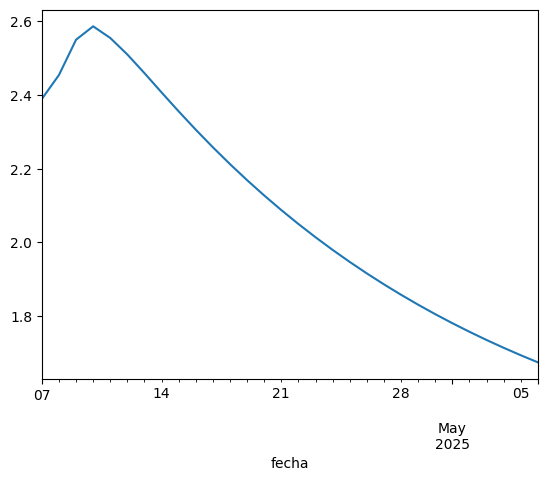

In [45]:
forecast_arima.plot()

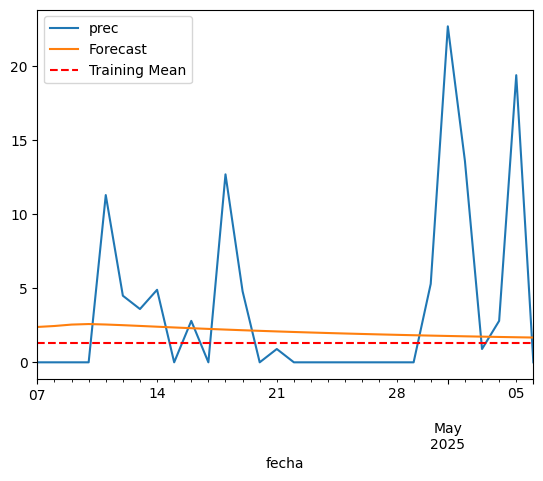

In [46]:
test_y.plot()
forecast_arima.plot(label='Forecast')
plt.axhline(y=train_y.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()

<Axes: xlabel='fecha'>

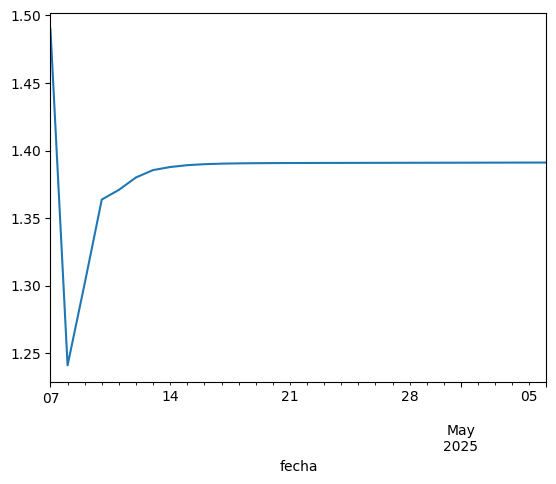

In [47]:
forecast_arima_exog.plot()

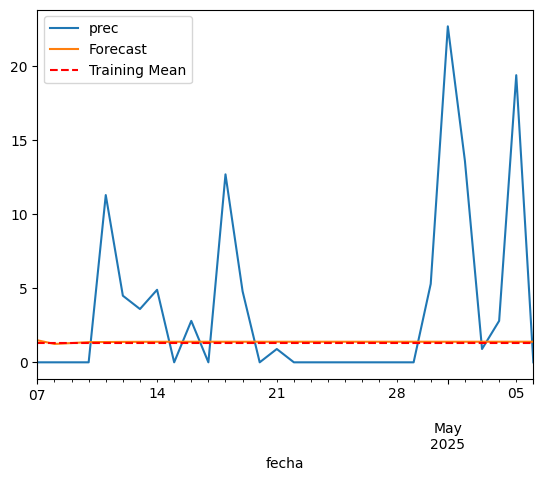

In [48]:
test_y.plot()
forecast_arima_exog.plot(label='Forecast')
plt.axhline(y=train_y.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()

# 6. Predicción de 30 días con datos de frecuencia SEMANAL

In [49]:
train_y_semanal = df_st_train['prec'].resample('W').mean()
train_x_semanal = df_st_train.drop(columns=['prec']).resample('W').mean()
test_y_semanal = df_st_test['prec'].resample('W').mean().iloc[0:4] # 30 días de test son 4 semanas y 2 días. Por lo tanto, se queda con 4 semanas

## 6.1 ARIMA sin Exógenas

In [50]:
warnings.filterwarnings("ignore")

stepwise_model_semanal = auto_arima(
    train_y_semanal,
    start_p=0,
    start_q=0,
    max_p=30,
    max_q=30,
    seasonal=True,
    trace=True,
    suppress_warnings=True,
    error_action='raise'
)
stepwise_model_semanal.fit(train_y_semanal)
forecast_arima_semanal = stepwise_model_semanal.predict(n_periods=len(test_y_semanal))
forecast_arima_semanal = pd.Series(forecast_arima_semanal)
forecast_arima_semanal.index = test_y_semanal.index

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4414.307, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4379.811, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4385.129, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4717.700, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4375.138, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4372.533, Time=0.21 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4374.508, Time=0.30 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4374.431, Time=0.73 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4373.175, Time=0.40 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=4376.359, Time=1.13 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4466.086, Time=0.14 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 3.363 seconds


In [51]:
rmse_arima_semanal = root_mean_squared_error(test_y_semanal, forecast_arima_semanal)
mae_arima_semanal = mean_absolute_error(test_y_semanal, forecast_arima_semanal)
mape_arima_semanal = mean_absolute_percentage_error(test_y_semanal, forecast_arima_semanal)

print("ARIMA (sin exógenas) Métricas:")
print("RMSE:", rmse_arima_semanal)
print("MAE:", mae_arima_semanal)
print(f"MAPE: {mape_arima_semanal:.2%}")

ARIMA (sin exógenas) Métricas:
RMSE: 2.742150477661811
MAE: 2.1607165667024244
MAPE: 391.82%


## 6.2 ARIMA con Exógenas

In [52]:
warnings.filterwarnings("ignore")

stepwise_model_semanal_exog = auto_arima(
    train_y_semanal,
    X = train_x_semanal,
    start_p=0,
    start_q=0,
    max_p=30,
    max_q=30,
    seasonal=True,
    trace=True,
    suppress_warnings=True,
    error_action='raise'
)
stepwise_model_semanal_exog.fit(train_y_semanal)
forecast_arima_exog_semanal = stepwise_model_semanal_exog.predict(n_periods=len(test_y_semanal))
forecast_arima_exog_semanal = pd.Series(forecast_arima_exog_semanal)
forecast_arima_exog_semanal.index = test_y_semanal.index

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4299.068, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4068.728, Time=3.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3814.134, Time=3.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4297.072, Time=1.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3797.783, Time=4.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3798.215, Time=4.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3812.590, Time=3.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3799.798, Time=3.56 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4000.826, Time=4.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3797.698, Time=3.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3796.772, Time=3.98 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3800.963, Time=3.91 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3799.131, Time=5.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3799.071, Time=5.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept

In [53]:
exog_rmse_arima_semanal = root_mean_squared_error(test_y_semanal, forecast_arima_exog_semanal)
exog_mae_arima_semanal = mean_absolute_error(test_y_semanal, forecast_arima_exog_semanal)
exog_mape_arima_semanal = mean_absolute_percentage_error(test_y_semanal, forecast_arima_exog_semanal)

print("ARIMA (con exógenas) Métricas:")
print("RMSE:", exog_rmse_arima_semanal)
print("MAE:", exog_mae_arima_semanal)
print(f"MAPE: {exog_mape_arima_semanal:.2%}")

ARIMA (con exógenas) Métricas:
RMSE: 2.858274715032279
MAE: 2.1761008745466133
MAPE: 269.52%


## 6.3 Resultados graficados

<Axes: xlabel='fecha'>

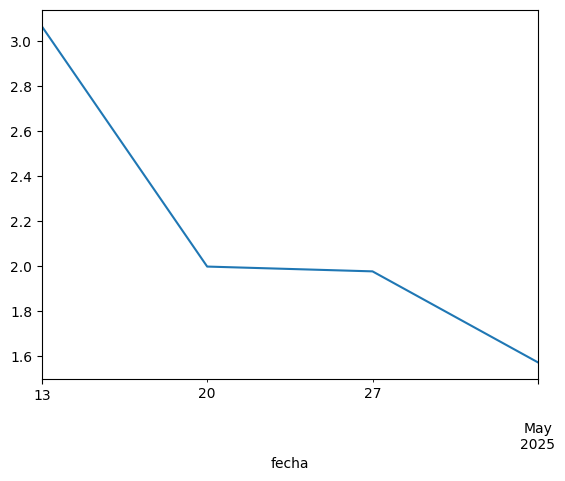

In [54]:
forecast_arima_semanal.plot()

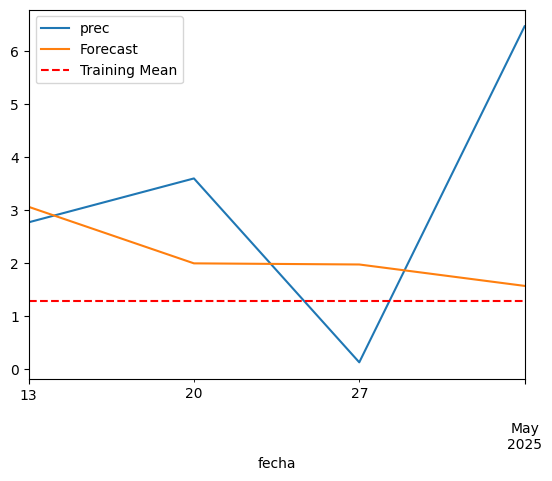

In [55]:
test_y_semanal.plot()
forecast_arima_semanal.plot(label='Forecast')
plt.axhline(y=train_y_semanal.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()

<Axes: xlabel='fecha'>

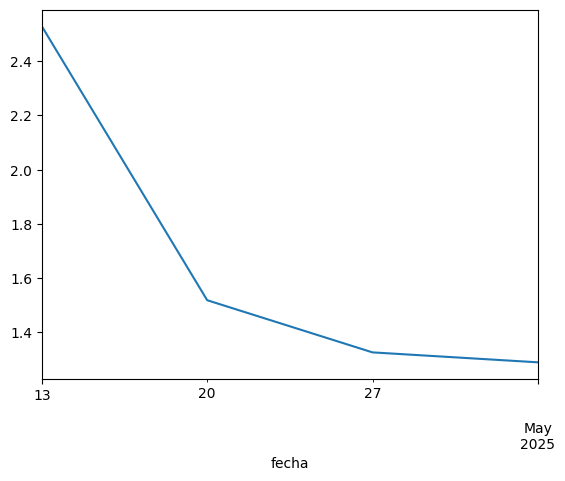

In [56]:
forecast_arima_exog_semanal.plot()

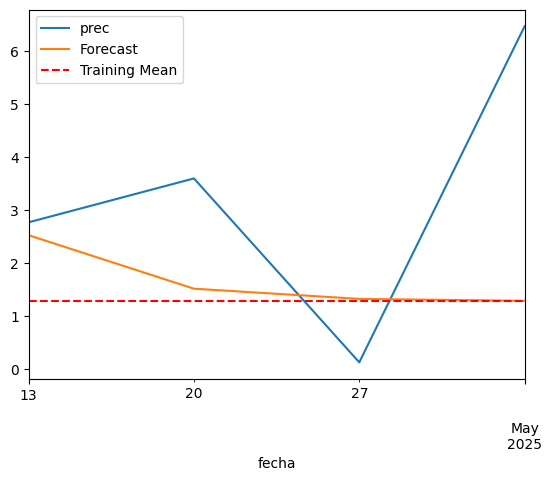

In [57]:
test_y_semanal.plot()
forecast_arima_exog_semanal.plot(label='Forecast')
plt.axhline(y=train_y_semanal.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()

# 7. Predicción de 30 días con datos de frecuencia MENSUAL

In [58]:
train_y_mensual = df_st_train['prec'].resample('M').mean()
train_x_mensual = df_st_train.drop(columns=['prec']).resample('M').mean()
test_y_mensual = df_st_test['prec'].resample('M').mean()

## 7.1 ARIMA sin Exógenas

In [59]:
warnings.filterwarnings("ignore")

stepwise_model_mensual = auto_arima(
    train_y_mensual,
    start_p=0,
    start_q=0,
    max_p=30,
    max_q=30,
    seasonal=True,
    trace=True,
    suppress_warnings=True,
    error_action='raise'
)
stepwise_model_mensual.fit(train_y_mensual)
forecast_arima_mensual = stepwise_model_mensual.predict(n_periods=len(test_y_mensual))
forecast_arima_mensual = pd.Series(forecast_arima_mensual)
forecast_arima_mensual.index = test_y_mensual.index

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=794.189, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=775.714, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=775.548, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=951.729, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=776.745, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=775.697, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=777.571, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=875.280, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.524 seconds


In [60]:
rmse_arima_mensual= root_mean_squared_error(test_y_mensual, forecast_arima_mensual)
mae_arima_mensual= mean_absolute_error(test_y_mensual, forecast_arima_mensual)
mape_arima_mensual= mean_absolute_percentage_error(test_y_mensual, forecast_arima_mensual)

print("ARIMA (sin exógenas) Métricas:")
print("RMSE:", rmse_arima_mensual)
print("MAE:", mae_arima_mensual)
print(f"MAPE: {mape_arima_mensual:.2%}")

ARIMA (sin exógenas) Métricas:
RMSE: 6.109194408222886
MAE: 4.7750724560756375
MAPE: 66.14%


## 7.2 ARIMA con Exógenas

In [61]:
warnings.filterwarnings("ignore")

stepwise_model_exog_mensual = auto_arima(
    train_y_mensual,
    X = train_x_mensual,
    start_p=0,
    start_q=0,
    max_p=30,
    max_q=30,
    seasonal=True,
    trace=True,
    suppress_warnings=True,
    error_action='raise'
)
stepwise_model_exog_mensual.fit(train_y_mensual)
forecast_arima_exog_mensual = stepwise_model_exog_mensual.predict(n_periods=len(test_y_mensual))
forecast_arima_exog_mensual = pd.Series(forecast_arima_exog_mensual)
forecast_arima_exog_mensual.index = test_y_mensual.index

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=735.929, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=691.711, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=645.776, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=734.098, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=649.662, Time=1.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=643.046, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=646.025, Time=1.62 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=646.033, Time=1.67 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=646.064, Time=1.48 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=642.384, Time=1.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=642.379, Time=1.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=646.077, Time=1.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=689.998, Time=0.73 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=645.063, Time=1.42 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          


In [62]:
exog_rmse_arima_mensual = root_mean_squared_error(test_y_mensual, forecast_arima_exog_mensual)
exog_mae_arima_mensual = mean_absolute_error(test_y_mensual, forecast_arima_exog_mensual)
exog_mape_arima_mensual = mean_absolute_percentage_error(test_y_mensual, forecast_arima_exog_mensual)

print("ARIMA (con exógenas) Métricas:")
print("RMSE:", exog_rmse_arima_mensual)
print("MAE:", exog_mae_arima_mensual)
print(f"MAPE: {exog_mape_arima_mensual:.2%}")

ARIMA (con exógenas) Métricas:
RMSE: 6.032030928869404
MAE: 4.608722999095589
MAPE: 59.87%


## 7.3 Resultados graficados

<Axes: xlabel='fecha'>

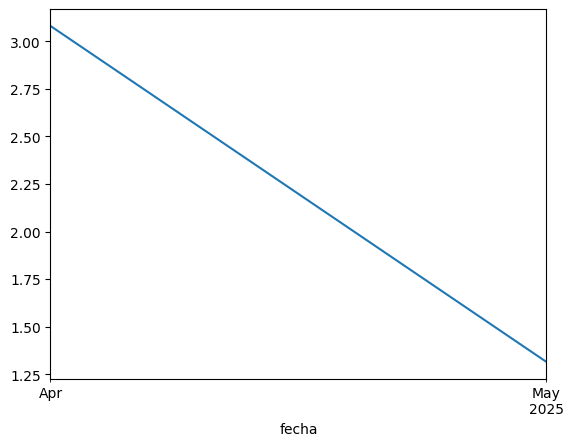

In [63]:
forecast_arima_mensual.plot()

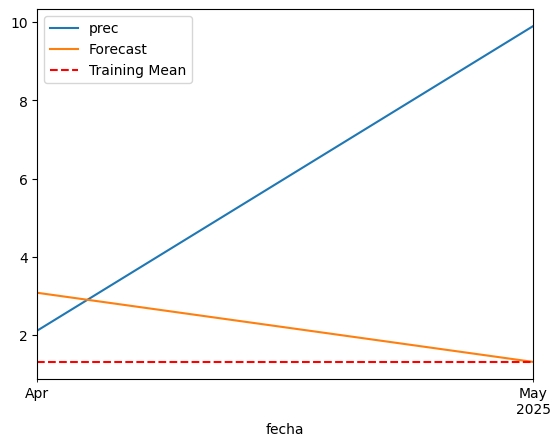

In [64]:
test_y_mensual.plot()
forecast_arima_mensual.plot(label='Forecast')
plt.axhline(y=train_y_mensual.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()

<Axes: xlabel='fecha'>

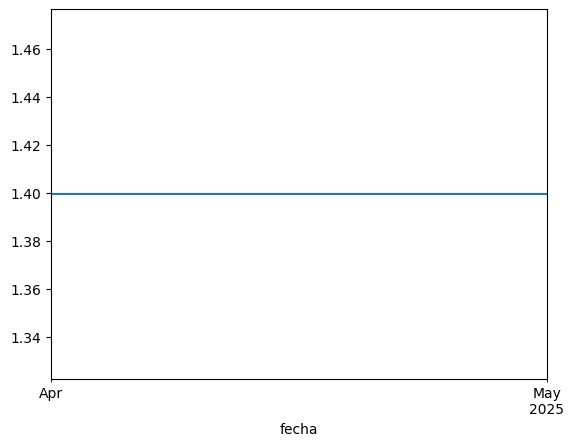

In [65]:
forecast_arima_exog_mensual.plot()

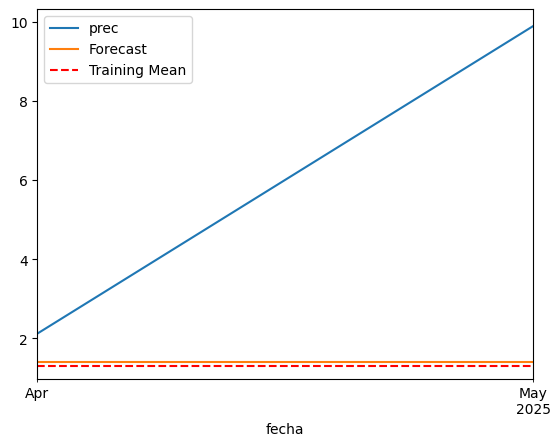

In [66]:
test_y_mensual.plot()
forecast_arima_exog_mensual.plot(label='Forecast')
plt.axhline(y=train_y_mensual.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()

# 8. Exportación de los conjuntos de datos creados

In [67]:
df.to_excel('df.xlsx')
df_st.to_excel('df_st.xlsx')
df_st_train.to_excel('df_st_train.xlsx')
df_st_test.to_excel('df_st_test.xlsx')

# Conjuntos de entrenamiento

train_x.to_excel('train_x.xlsx')
train_x_semanal.to_excel('train_x_semanal.xlsx')
train_x_mensual.to_excel('train_x_mensual.xlsx')

train_y.to_excel('train_y.xlsx')
train_y_semanal.to_excel('train_y_semanal.xlsx')
train_y_mensual.to_excel('train_y_mensual.xlsx')

# Conjuntos de test

test_y.to_excel('test_y.xlsx')
test_y_semanal.to_excel('test_y_semanal.xlsx')
test_y_mensual.to_excel('test_y_mensual.xlsx')

In [68]:
datos_arima = {
    "Modelo": [
        "ARIMA (sin exógenas)",
        "ARIMA (con exógenas)",
        "ARIMA (semanal sin exógenas)",
        "ARIMA (semanal con exógenas)",
        "ARIMA (mensual sin exógenas)",
        "ARIMA (mensual con exógenas)"
    ],
    "Parámetros óptimos": [
        str(stepwise_model.order),
        str(stepwise_model_exog.order),
        str(stepwise_model_semanal.order),
        str(stepwise_model_semanal_exog.order),
        str(stepwise_model_mensual.order),
        str(stepwise_model_exog_mensual.order)
    ]
}

# Crear DataFrame
df = pd.DataFrame(datos_arima)

# Guardar en Excel
df.to_excel("parametros_ARIMA_optimos.xlsx", index=False)

# 9. Forecast rolling se ajusta más a la serie temporal de acuerdo con lo visto en el siguiente notebook:

https://github.com/Ag994/time-series-analysis-and-forecasting-Using-Arima-auto-Arima-and-prophet/blob/main/time%20series%20analysis.ipynb

In [69]:
# Versión con predicción futura
# Crear Series con índices predefinidos y añadir 30 días más

df_st_mensual = df_st.resample('M').mean().sort_index(ascending=True)

# Crear índice extendido (30 días más)
ultimo_dia = df_st_mensual.index[-1]
dias_adicionales = pd.date_range(start=ultimo_dia, periods=31, freq='M')[1:]
indice_extendido = df_st_mensual.index[30:].union(dias_adicionales)

# Crear Series con el índice extendido
predictions = pd.Series(index=indice_extendido)

# Realizar predicciones históricas
for i in range(30, len(df_st_mensual)):
    window_data = df_st.iloc[0:i]
    model = ARIMA(
        order=stepwise_model_mensual.order,
        seasonal_order=stepwise_model_mensual.seasonal_order,
        suppress_warnings=True
    )
    results = model.fit(window_data['prec'])
    forecast = results.predict(n_periods=1)
    predictions.iloc[i-30] = float(forecast)

# Realizar predicciones futuras
ultima_ventana = df_st
model = ARIMA(
    order=stepwise_model_mensual.order,
    seasonal_order=stepwise_model_mensual.seasonal_order,
    suppress_warnings=True
)
results = model.fit(ultima_ventana['prec'])
forecast_future = results.predict(n_periods=30)

# Asignar predicciones futuras
predictions.iloc[-30:] = forecast_future

# Asegurar que no hay valores negativos
predictions = predictions.clip(lower=0)

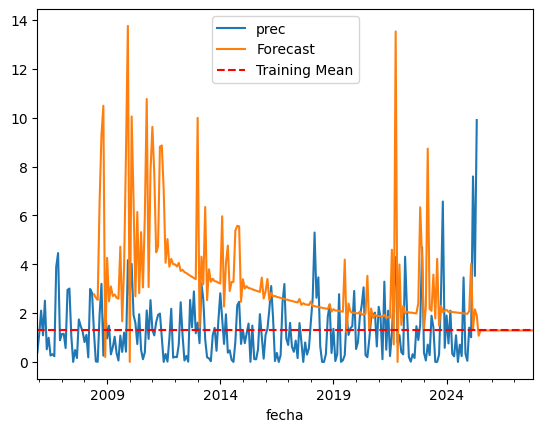

In [70]:
df_st_mensual["prec"].plot()
predictions.plot(label='Forecast')
plt.axhline(y=train_y_mensual.mean(), color='r', linestyle='--', label='Training Mean')
plt.legend()
plt.show()